# CH7 범주형 데이터 이진분류 경진대회

## 7.5 성능 개선 2
- 7.4 절에서는 훈련 데이터의 일부(10%)를 떼어서 검증(valid) 데이터로 사용했다  
- 즉 훈련데이터의 10%는 모델 학습에 사용되지 않았다  
- 7.5에서는 성능개선을 위해 검증 데이터를 따로 떼어놓지 않고, 훈련 데이터 전부를 학습에 쓰겠다  
  ->7.4의 코드에서 train_test_split()으로 검증데이터를 떼어놓는 부분만 제외하고 재사용  

In [1]:
import pandas as pd
data_path = '/kaggle/input/cat-in-the-dat/'
train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

# 훈련 데이터와 테스트 데이터 합치기 
all_data = pd.concat([train, test]) 
all_data = all_data.drop('target', axis=1) # 타깃값 제거

# bin_0~2는 이미 0과 1로 표현되어 있으므로, bin_3~4만 인코딩하면 됨
all_data['bin_3'] = all_data['bin_3'].map({'F':0, 'T':1})
all_data['bin_4'] = all_data['bin_4'].map({'N':0, 'Y':1})

In [2]:
from sklearn.preprocessing import OrdinalEncoder

#(1) ord_0은 이미 숫자 데이터이므로 인코딩 필요 없음
#(2) ord_1, ord_2를 고윳값의 순서에 맞춰 인코딩
ord1dict = {'Novice':0, 'Contributor':1, 'Expert':2, 'Master':3, 'Grandmaster':4}
ord2dict = {'Freezing':0, 'Cold':1, 'Warm':2, 'Hot':3, 'Boiling Hot':4, 'Lava Hot':5}
all_data['ord_1'] = all_data['ord_1'].map(ord1dict) 
all_data['ord_2'] = all_data['ord_2'].map(ord2dict)

#(3) ord_3~5를 각각 고윳값의 알파벳 순서에 맞춰 인코딩
ord_345 = ['ord_3', 'ord_4', 'ord_5']
ord_encoder = OrdinalEncoder() # OrdinalEncoder 객체 생성
# ordinal 인코딩 적용
all_data[ord_345] = ord_encoder.fit_transform(all_data[ord_345])

In [3]:
from sklearn.preprocessing import OneHotEncoder

nom_features = ['nom_' + str(i) for i in range(10)] # 명목형 피처 리스트

# 원-핫 인코딩 적용
onehot_encoder = OneHotEncoder() # OneHotEncoder 객체 생성
encoded_nom_matrix = onehot_encoder.fit_transform(all_data[nom_features])
all_data = all_data.drop(nom_features, axis=1) # 중복을 막기 위해 기존 명목형 피처 삭제

In [4]:
date_features = ['day', 'month'] # 날짜 피처
# 원-핫 인코딩 적용
encoded_date_matrix = onehot_encoder.fit_transform(all_data[date_features])
all_data = all_data.drop(date_features, axis=1) # 기존 날짜 피처 삭제
encoded_date_matrix

<500000x19 sparse matrix of type '<class 'numpy.float64'>'
	with 1000000 stored elements in Compressed Sparse Row format>

In [5]:
from sklearn.preprocessing import MinMaxScaler
ord_features = ['ord_' + str(i) for i in range(6)] # 순서형 피처
# min-max 정규화
all_data[ord_features] = MinMaxScaler().fit_transform(all_data[ord_features])

In [ ]:
from scipy import sparse
import numpy as np

all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data), encoded_nom_matrix, encoded_date_matrix], format='csr')

In [ ]:
num_train = len(train) # 훈련 데이터 개수
# 훈련 데이터와 테스트 데이터 나누기 
X_train = all_data_sprs[:num_train] # 0~num_train 행 
X_test = all_data_sprs[num_train:] # ~마지막 행
y = train['target']

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression

############ 하이퍼파라미터 최적화 
# 로지스틱 회귀 모델 생성
logistic_model = LogisticRegression()
# 하이퍼파라미터 값 목록 
lr_params = {'C':[0.1, 0.125, 0.2], 'max_iter':[800, 900, 1000], 'solver':['liblinear'], 'random_state':[42]}
# 그리드서치 객체 생성
gridsearch_logistic_model = GridSearchCV(estimator=logistic_model, param_grid=lr_params, scoring='roc_auc', cv=5)
# 그리드서치 수행
gridsearch_logistic_model.fit(X_train, y)
print('최적 하이퍼파라미터：', gridsearch_logistic_model.best_params_)

최적 하이퍼파라미터： {'C': 0.125, 'max_iter': 800, 'random_state': 42, 'solver': 'liblinear'}
CPU times: user 22min 46s, sys: 18min 25s, total: 41min 11s
Wall time: 10min 47s


In [ ]:

###### 예측 및 제출 
y_preds = gridsearch_logistic_model.best_estimator_.predict_proba(X_test)[:,1]
submission['target'] = y_preds
submission.to_csv('submission.csv')

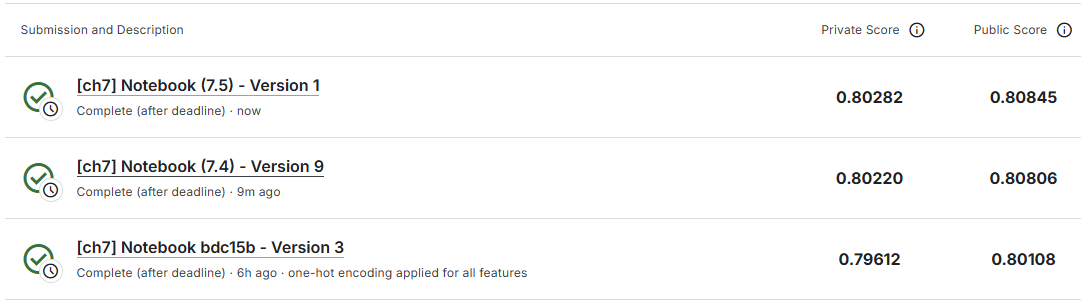  
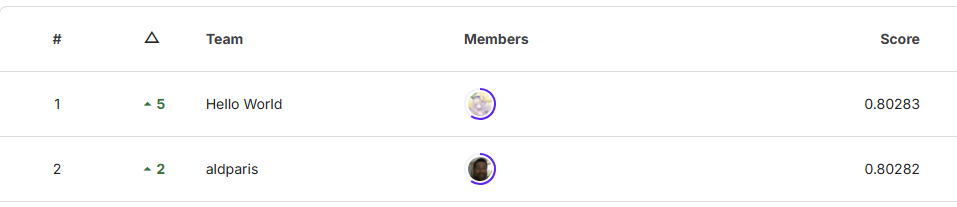
- 책의 과정을 따라가며 최종적으로 얻은 결과는 0.80282로, 리더보드 2위에 해당하는 숫자이다. 

# 실전 문제
## 범주형 데이터 이진분류 경진대회 2에 도전하기
